In [169]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [170]:
data = pd.read_csv('../Fertility/00_data/intermidate/fertility_nuts.csv')

In [171]:
data

,Country code,NUTS Code,NUTS label,NUTS level,TIME_PERIOD,edu_index,birth,population,population_last_year,logbirth,logpop,logedu
0,AT,AT111,Mittelburgenland,3,2016,0.617119,280,37692,37622.0,5.634790,10.535344,-0.482678
1,AT,AT111,Mittelburgenland,3,2017,0.614284,266,37752,37692.0,5.583496,10.537203,-0.487282
2,AT,AT111,Mittelburgenland,3,2018,0.618892,282,37661,37752.0,5.641907,10.538794,-0.479809
3,AT,AT111,Mittelburgenland,3,2019,0.625676,231,37513,37661.0,5.442418,10.536380,-0.468906
4,AT,AT111,Mittelburgenland,3,2020,0.631149,221,37384,37513.0,5.398163,10.532443,-0.460198
...,...,...,...,...,...,...,...,...,...,...,...,...
7653,SK,SK042,Košický kraj,3,2018,0.590342,8951,799217,798103.0,9.099521,13.589993,-0.527037
7654,SK,SK042,Košický kraj,3,2019,0.593510,8821,800414,799217.0,9.084891,13.591388,-0.521685
7655,SK,SK042,Košický kraj,3,2020,0.618950,8782,801460,800414.0,9.080459,13.592884,-0.479715
7656,SK,SK042,Košický kraj,3,2021,0.619418,8765,802092,801460.0,9.078522,13.594190,-0.478959


In [172]:
data['TIME_PERIOD'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

def calculate_slope(series):
    if len(series) >= 2:
        y = series.values[-2:]  # Use the last two points
        x = np.array([1, 2])  # Indices for these points
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        return m
    else:
        return 0
    
def scaling(data, col):
    df = pd.DataFrame()
    for y in range(2015, 2022):
        data1 = data.loc[data['TIME_PERIOD'] == y, ['NUTS label', 'TIME_PERIOD', 'logpop', col]].copy().dropna()
        if not data1.empty:
            data1['logvalue'] = data1[col]
            lm = smf.ols(formula='logvalue ~ logpop', data=data1).fit()
            data1['beta'] = lm.params['logpop']
            data1['beta_error'] = lm.bse['logpop']
            data1['SAMI'] = data1['logvalue'] - (lm.params['logpop'] * data1['logpop'] + lm.params['Intercept'])
            df = pd.concat([df, data1])

    # Beta time series with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(df['TIME_PERIOD'], df['beta'], yerr=df['beta_error'], fmt='o', capsize=5, color='#FFBE7A')
    plt.axhline(y=1, color='black', linestyle='--')
    plt.title('Beta over Time for {}'.format(col), fontsize=14)
    plt.show()

    # Calculate significant cities for labels
    final_year_data = df[df['TIME_PERIOD'] == df['TIME_PERIOD'].max()]
    top_cities = final_year_data.nlargest(5, 'SAMI')['NUTS label'].tolist()
    bottom_cities = final_year_data.nsmallest(5, 'SAMI')['NUTS label'].tolist()

    # SAMI time series of each city
    plt.figure(figsize=(18, 8))
    city_colors = {city: plt.cm.tab20(i % 20) for i, city in enumerate(df['NUTS label'].unique())}
    label_positions = {}

    # For alternating label positions
    def alternate_positions(cities, start_left=True):
        positions = {}
        left = start_left
        for city in cities:
            positions[city] = 'left' if left else 'right'
            left = not left
        return positions

    label_side = alternate_positions(top_cities + bottom_cities)

    for city in df['NUTS label'].unique():
        city_data = df[df['NUTS label'] == city]
        if not city_data.empty and len(city_data['SAMI']) >= 2:
            slope = calculate_slope(city_data['SAMI'].tail(10))
            color = '#D3D3D3'
            if city in top_cities or city in bottom_cities:
                color = '#FA7F6F' if city in top_cities else '#BEB8DC'
                y_pos = city_data['SAMI'].iloc[-1] + (0.02 if slope > 0 else -0.02)
                ha = label_side[city]
                plt.text(df['TIME_PERIOD'].max(), y_pos, city, fontsize=9, color=color, ha=ha)

            plt.plot(city_data['TIME_PERIOD'], city_data['SAMI'], label=None if city not in top_cities and city not in bottom_cities else city, color=color, alpha=0.75 if city in top_cities or city in bottom_cities else 0.25)

    plt.title('SAMI over Time for Each NUTS3 Region')
    plt.xlabel('Year')
    plt.ylabel('SAMI')
    plt.tight_layout()
    plt.show()

    # Average SAMI bar chart
    plt.figure(figsize=(150, 25))
    sami_means = df.groupby('NUTS label')['SAMI'].mean().sort_values(ascending=False)
    sami_means.plot(kind='bar', color=[city_colors[city] for city in sami_means.index],width=1)
    plt.title('Average SAMI for Each NUTS3 Region', fontsize=80)
    plt.xticks(rotation=90, fontsize=6)
    plt.tight_layout()


    plt.show()

    return(label_side)


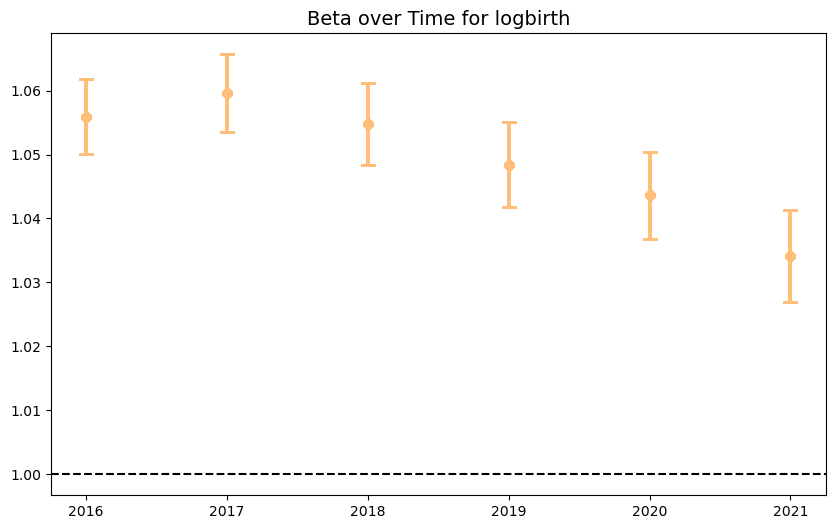

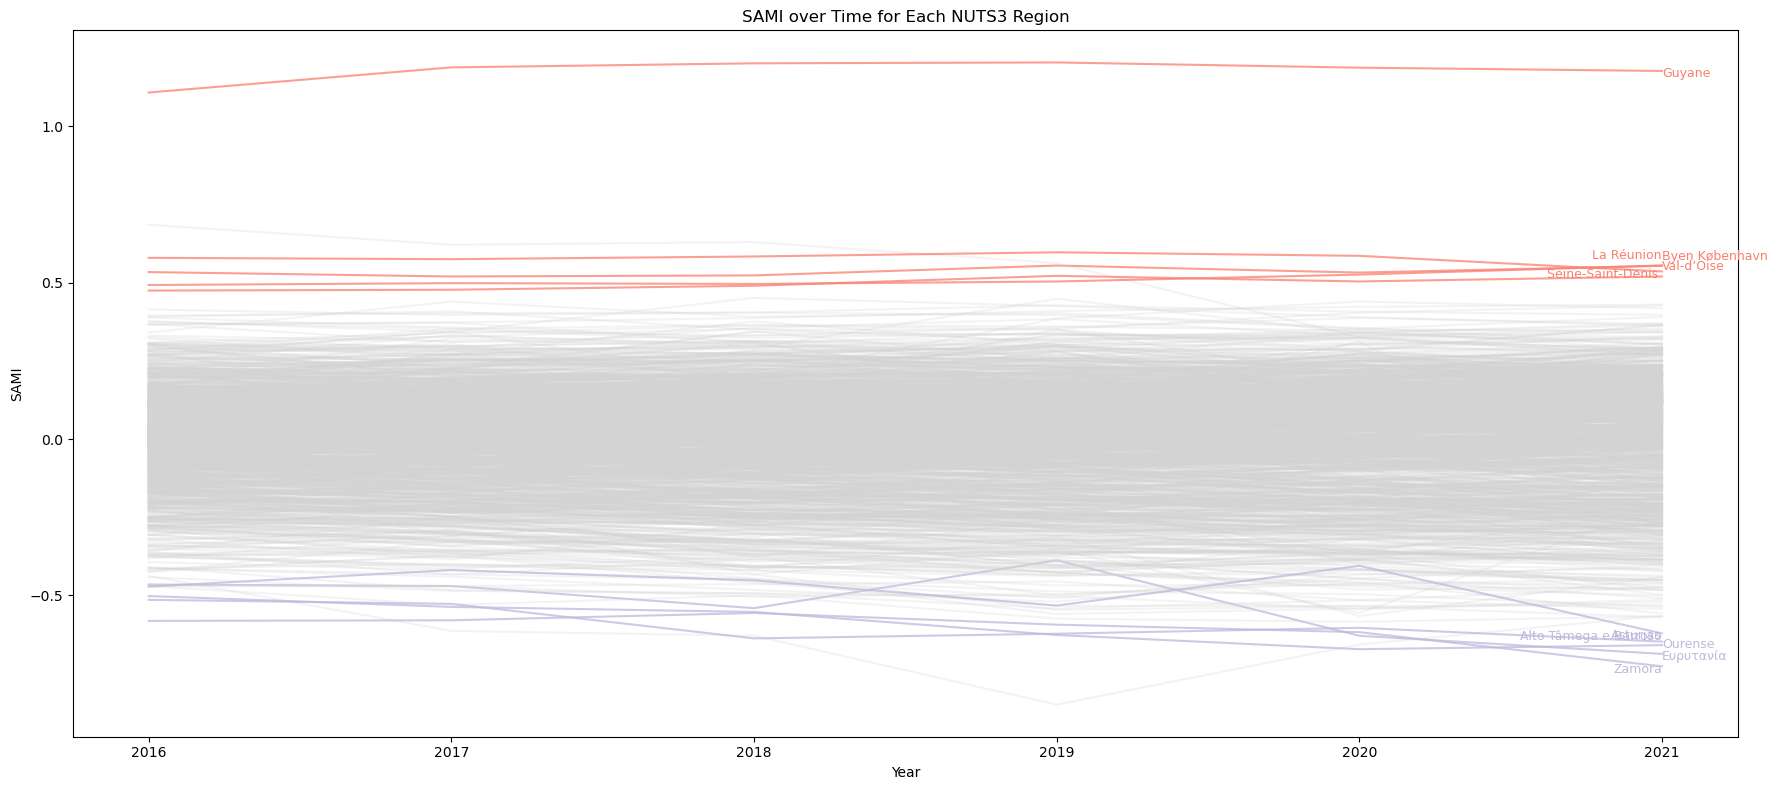

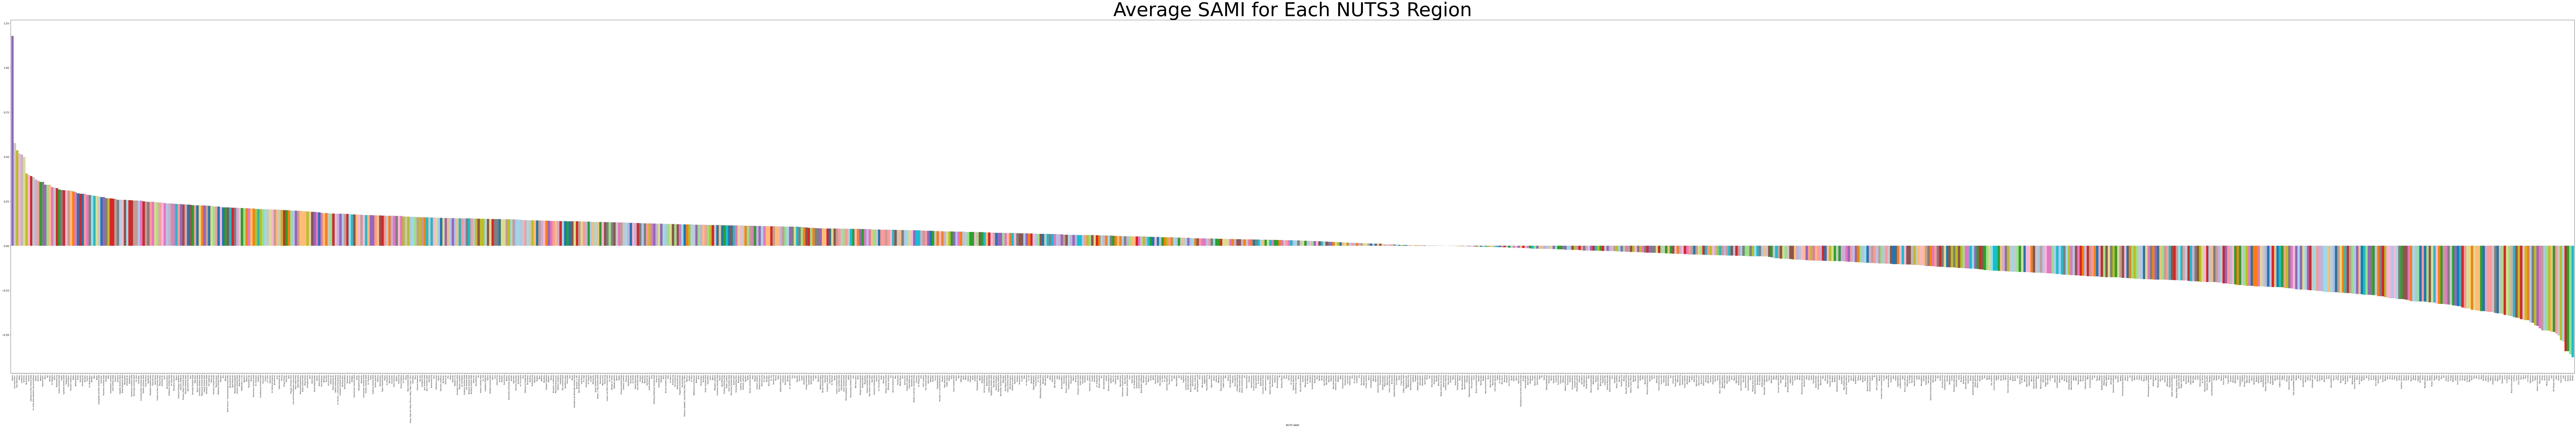

{'Guyane': 'left',
 'La Réunion': 'right',
 'Byen København': 'left',
 'Seine-Saint-Denis ': 'right',
 'Val-d’Oise': 'left',
 'Zamora': 'right',
 'Ευρυτανία': 'left',
 'Asturias': 'right',
 'Ourense': 'left',
 'Alto Tâmega e Barroso': 'right'}

In [178]:
scaling(data, 'logbirth')

In [29]:
data['Country code'].unique()

array(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI',
       'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL',
       'PT', 'RO', 'SE', 'SI', 'SK'], dtype=object)

In [49]:
import pandas as pd
import numpy as np
from pysal.lib import weights
from pysal.explore import esda

# Load the data
fertility_data = pd.read_csv('../Fertility/00_data/intermidate/fertility_nuts.csv')
distance_data = pd.read_csv('../Fertility/00_data/raw/4_Distance.csv')

# Filter the data for the year 2020
data_2020 = fertility_data[fertility_data['TIME_PERIOD'] == 2020]



In [57]:
data_2020

,Country code,NUTS Code,NUTS label,NUTS level,TIME_PERIOD,edu_index,birth,population,population_last_year,logbirth,logpop,logedu
4,AT,AT111,Mittelburgenland,3,2020,0.631149,221,37384,37513.0,5.398163,10.532443,-0.460198
11,AT,AT112,Nordburgenland,3,2020,0.631149,1275,160064,158981.0,7.150701,11.976540,-0.460198
18,AT,AT113,Südburgenland,3,2020,0.631149,604,96988,96939.0,6.403574,11.481837,-0.460198
25,AT,AT121,Mostviertel-Eisenwurzen,3,2020,0.597704,2396,247347,246740.0,7.781556,12.416090,-0.514642
32,AT,AT122,Niederösterreich-Süd,3,2020,0.597704,2408,261156,260480.0,7.786552,12.470281,-0.514642
...,...,...,...,...,...,...,...,...,...,...,...,...
7627,SK,SK023,Nitriansky kraj,3,2020,0.601589,5832,674306,676672.0,8.671115,13.424942,-0.508164
7634,SK,SK031,Žilinský kraj,3,2020,0.602437,7247,691509,691368.0,8.888343,13.446428,-0.506756
7641,SK,SK032,Banskobystrický kraj,3,2020,0.602437,5978,645276,647874.0,8.695841,13.381452,-0.506756
7648,SK,SK041,Prešovský kraj,3,2020,0.618950,9997,826244,825022.0,9.210040,13.623165,-0.479715


In [37]:
distance_data

,Unnamed: 0,NUTS,NAME,AL011,AL012,AL013,AL014,AL015,AL021,AL022,...,TRB24,TRC11,TRC12,TRC13,TRC21,TRC22,TRC31,TRC32,TRC33,TRC34
0,0,AL011,Dibër,0.000000,0.630100,0.589938,0.434000,0.772924,0.555151,0.558302,...,24.177176,17.716145,18.446475,17.555259,19.357604,20.408224,21.033288,21.450582,22.653967,22.201003
1,1,AL012,Durrës,0.630100,0.000000,0.966765,0.416714,0.733122,0.690957,0.242656,...,24.752368,18.268214,19.012690,18.101459,19.918437,20.983650,21.600332,22.026364,23.226172,22.777580
2,2,AL013,Kukës,0.589938,0.966765,0.000000,0.555667,0.525169,1.144310,1.029078,...,24.282789,17.873285,18.574853,17.723416,19.496455,20.515144,21.158293,21.556110,22.766963,22.304327
3,3,AL014,Lezhë,0.434000,0.416714,0.555667,0.000000,0.398527,0.823610,0.534189,...,24.593046,18.141098,18.866562,17.981824,19.779654,20.824158,21.452904,21.866286,23.071300,22.616280
4,4,AL015,Shkodër,0.772924,0.733122,0.525169,0.398527,0.000000,1.221098,0.909533,...,24.793872,18.371201,19.080468,18.218039,19.999525,21.025746,21.664915,22.067066,23.276408,22.815777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,1279,TRC22,Diyarbakır,20.408224,20.983650,20.515144,20.824158,21.025746,20.363482,20.793422,...,3.768952,3.145212,2.080668,3.475711,1.512670,0.000000,0.907827,1.042974,2.260309,1.796019
1280,1280,TRC31,Mardin,21.033288,21.600332,21.158293,21.452904,21.664915,20.970743,21.405448,...,3.224757,3.475765,2.587987,3.751235,1.738667,0.907827,0.000000,0.824743,1.677675,1.413288
1281,1281,TRC32,Batman,21.450582,22.026364,21.556110,21.866286,22.067066,21.406424,21.836275,...,2.726859,4.103493,3.095088,4.410480,2.388423,1.042974,0.824743,0.000000,1.240325,0.753977
1282,1282,TRC33,Şırnak,22.653967,23.226172,22.766963,23.071300,23.276408,22.601885,23.033969,...,1.548721,5.153420,4.235577,5.425424,3.416272,2.260309,1.677675,1.240325,0.000000,0.591773


In [47]:
data_2020 = data_2020.loc[data['Country code'] != 'EL']

In [43]:
# Function to create spatial weights from a distance matrix dataframe
from scipy.sparse import csr_matrix

def morans_i(values, weights_matrix):
    """
    Calculate Moran's I for spatial autocorrelation.
    :param values: numpy array of the attribute (e.g., unemployment rate, income)
    :param weights_matrix: numpy array representing the spatial weights matrix
    :return: Moran's I value
    """
    n = len(values)
    mean_value = np.mean(values)
    S0 = np.sum(weights_matrix)
    denominator = np.sum((values - mean_value) ** 2)
    
    numerator = 0
    for i in range(n):
        for j in range(n):
            numerator += weights_matrix[i, j] * (values[i] - mean_value) * (values[j] - mean_value)
            
    return (n / S0) * (numerator / denominator)

In [46]:
data['Country code'].unique()

array(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI',
       'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL',
       'PT', 'RO', 'SE', 'SI', 'SK'], dtype=object)

In [52]:
import pandas as pd
import numpy as np

def create_weights_from_distance(distance_data, nuts):
    # Attempt to subset the distance matrix to include only relevant NUTS codes
    try:
        relevant_distances = distance_data.set_index('NUTS').loc[nuts, nuts]
        # Check if all required NUTS codes are present
        if relevant_distances.shape[0] != len(nuts) or relevant_distances.shape[1] != len(nuts):
            return None  # Return None if any NUTS codes are missing
        relevant_distances.fillna(0, inplace=True)
        # Convert distances to inverse weights
        with np.errstate(divide='ignore', invalid='ignore'):
            inverse_weights = np.where(relevant_distances != 0, 1 / relevant_distances, 0)
            np.fill_diagonal(inverse_weights, 0)  # Ensure no self-loops
        return inverse_weights
    except KeyError:
        # Return None if subsetting fails due to missing NUTS codes
        return None

def morans_i(values, weights_matrix):
    if weights_matrix is None:
        return None  # Skip calculation if weights matrix is not available
    n = len(values)
    mean_value = np.mean(values)
    S0 = np.sum(weights_matrix)
    denominator = np.sum((values - mean_value) ** 2)
    
    numerator = 0
    for i in range(n):
        for j in range(n):
            numerator += weights_matrix[i, j] * (values[i] - mean_value) * (values[j] - mean_value)
            
    return (n / S0) * (numerator / denominator)

# Assuming 'data_2020' and 'distance_data' are loaded correctly
morans_results = {}  # Use a dictionary to store results by country code
for country_code in data_2020['Country code'].unique():
    df = data_2020.loc[data_2020['Country code'] == country_code]
    nuts = df['NUTS Code'].unique()
    # Create the weights matrix using the corrected function
    weights_matrix = create_weights_from_distance(distance_data, nuts)
    if weights_matrix is not None:  # Only calculate Moran's I if weights matrix is valid
        moran = morans_i(df['edu_index'].values, weights_matrix)
        if moran is not None:
            morans_results[country_code] = moran  # Store the result with the country code as the key

# Print the results for each country
for country, moran_index in morans_results.items():
    print(f"Moran's I for {country}: {moran_index}")

Moran's I for AT: 0.08020175768178235
Moran's I for BE: 0.07451460560026792
Moran's I for BG: 0.11357077720629127
Moran's I for CY: nan
Moran's I for CZ: -0.09809211132796783
Moran's I for DE: 0.07453289701533751
Moran's I for DK: 0.05075357400973774
Moran's I for EE: nan
Moran's I for ES: 0.21494623161150841
Moran's I for FI: 0.05364737135916163
Moran's I for HR: nan
Moran's I for HU: 0.023125906678450388
Moran's I for IE: -0.0018956855108919598
Moran's I for IT: 0.2405907342274148
Moran's I for LT: -0.09561660128718764
Moran's I for LU: nan
Moran's I for LV: nan
Moran's I for MT: nan
Moran's I for PL: 0.11259598083268298
Moran's I for PT: 0.07477540047312674
Moran's I for RO: 0.25195523640992956
Moran's I for SE: -0.044209025112656064
Moran's I for SI: 0.1122213192270481
Moran's I for SK: -0.22400722431473521


In [78]:
morans_df = pd.DataFrame(list(morans_results.items()), columns=['Country code', 'Moran'])

In [81]:
datafer = data_2020.groupby(by=['Country code'])[['birth','population']].sum().reset_index()

In [83]:
dfinal = pd.merge(morans_df.dropna(),datafer,on='Country code',how ='left')

In [89]:
dfinal['birth_rate'] = dfinal['birth']/dfinal['population']

In [90]:
dfinal

,Country code,Moran,birth,population,birth_rate
0,AT,0.080202,83603,8901064,0.009392
1,BE,0.074515,114350,11522440,0.009924
2,BG,0.113571,59086,6951482,0.008500
3,CZ,-0.098092,110200,10693939,0.010305
4,DE,0.074533,769035,82576617,0.009313
5,DK,0.050754,60937,5822763,0.010465
6,ES,0.214946,340635,47332614,0.007197
7,FI,0.053647,30263,3414955,0.008862
8,HU,0.023126,93798,9769526,0.009601
9,IE,-0.001896,55959,4964440,0.011272


In [93]:
import statsmodels.formula.api as smf
lm = smf.ols(formula='birth_rate~Moran', data = dfinal).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             birth_rate   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     6.999
Date:                Tue, 07 May 2024   Prob (F-statistic):             0.0176
Time:                        19:26:20   Log-Likelihood:                 98.999
No. Observations:                  18   AIC:                            -194.0
Df Residuals:                      16   BIC:                            -192.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0097      0.000     35.263      0.0

/Users/lidouhao/anaconda3/envs/study/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


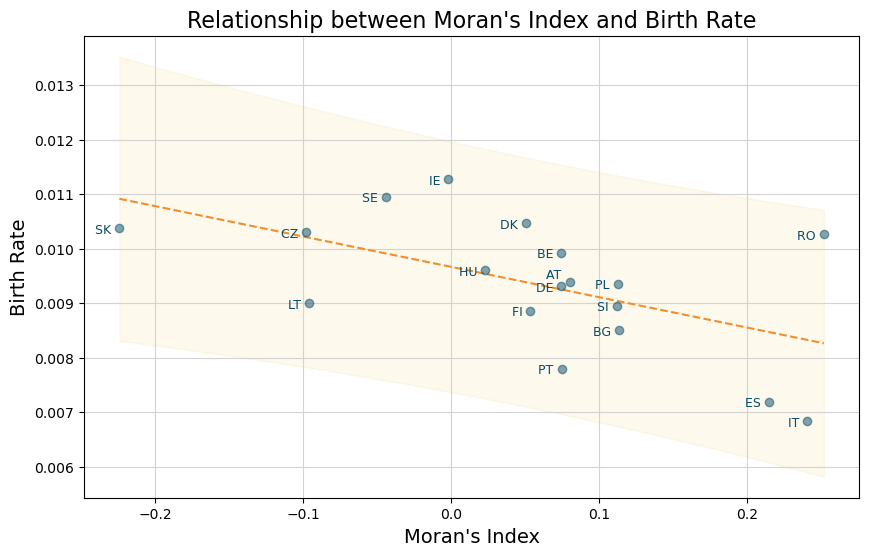

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Define the colors
line_color = "#074C6B" # Light gray-blue
fill_color = "#EDC949"
data = dfinal  # Assuming dfinal is your DataFrame with the data

# Fit a regression model
X = sm.add_constant(data['Moran'])  # adding a constant
model = sm.OLS(data['birth_rate'], X).fit()

# Predict values along the observed range of Moran's I
x_pred = np.linspace(data['Moran'].min(), data['Moran'].max(), 100)
x_pred2 = sm.add_constant(x_pred)  # add constant as we did before
y_pred = model.predict(x_pred2)

# Calculate confidence intervals for the predictions
_, upper, lower = wls_prediction_std(model, exog=x_pred2, alpha=0.05)

# Create a plot with custom colors
plt.figure(figsize=(10, 6))
plt.scatter(x='Moran', y='birth_rate', data=data, color=line_color,alpha=0.5,zorder=3)

# Plot regression line and confidence interval
plt.plot(x_pred, y_pred, '--', color="#F28E2C", label='Regression Line')  # regression line
plt.fill_between(x_pred, lower, upper, color=fill_color, alpha=0.1, label='Confidence Interval')

# Adding labels for each point slightly further from the data points
for i, txt in enumerate(data['Country code']):
    if txt == 'AT':
        plt.text(data['Moran'].iloc[i], data['birth_rate'].iloc[i], txt+'  ', fontsize=9, ha='right', va='bottom',color =line_color )
    else: 
        plt.text(data['Moran'].iloc[i], data['birth_rate'].iloc[i], txt+'  ', fontsize=9, ha='right', va='center_baseline',color =line_color )

# Setting plot title and labels
plt.title('Relationship between Moran\'s Index and Birth Rate', fontsize=16)
plt.xlabel('Moran\'s Index', fontsize=14)
plt.ylabel('Birth Rate', fontsize=14)

# Customizing the grid
ax = plt.gca()  # Get current axis
plt.grid(True, color="lightgray") 

# Saving the figure with a transparent background
plt.savefig('plot_with_transparency.png', transparent=True)

# Displaying the plot
plt.show()

In [167]:
model.summary()

/Users/lidouhao/anaconda3/envs/study/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             birth_rate   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     6.999
Date:                Tue, 07 May 2024   Prob (F-statistic):             0.0176
Time:                        21:21:20   Log-Likelihood:                 98.999
No. Observations:                  18   AIC:                            -194.0
Df Residuals:                      16   BIC:                            -192.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.000     35.263      0.000       0.009       0.010
Moran         -0.0056      0.002     -2.646      0.018      -0.010      -0.001
==============================================================================
Omnibus:                        0.422   Durbin-Watson:                   2.346
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.544
Skew:                           0.234   Prob(JB):                        0.762
Kurtosis:                       2.288   Cond. No.                         8.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

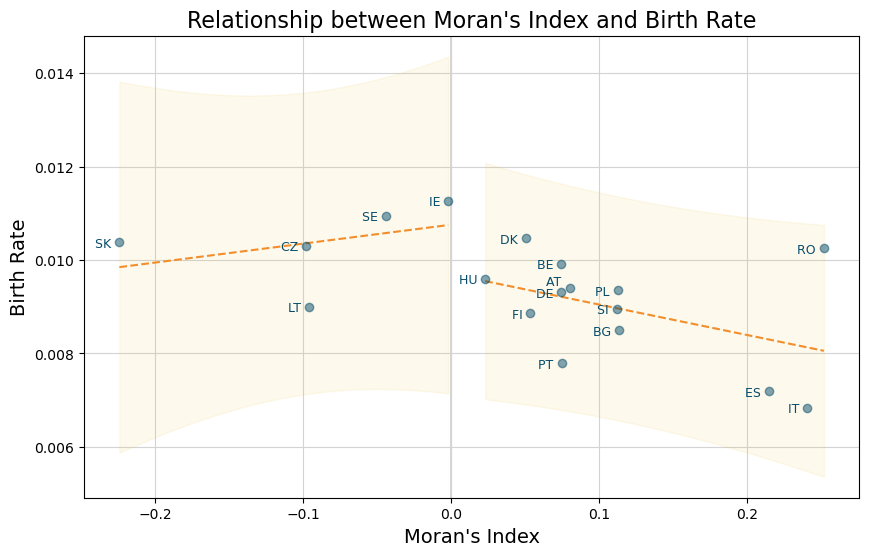

In [148]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Define the colors
line_color = "#074C6B"  # Light gray-blue
fill_color = "#EDC949"  # Used for confidence intervals

# Load your DataFrame
data = dfinal  # Replace dfinal with your actual DataFrame variable name

# Splitting the data based on Moran's Index
data_pos = data[data['Moran'] >= 0]
data_neg = data[data['Moran'] < 0]

# Fit regression model for Moran's Index >= 0
X_pos = sm.add_constant(data_pos['Moran'])
model_pos = sm.OLS(data_pos['birth_rate'], X_pos).fit()
x_pred_pos = np.linspace(data_pos['Moran'].min(), data_pos['Moran'].max(), 100)
x_pred2_pos = sm.add_constant(x_pred_pos)
y_pred_pos = model_pos.predict(x_pred2_pos)
_, upper_pos, lower_pos = wls_prediction_std(model_pos, exog=x_pred2_pos, alpha=0.05)

# Fit regression model for Moran's Index < 0
X_neg = sm.add_constant(data_neg['Moran'])
model_neg = sm.OLS(data_neg['birth_rate'], X_neg).fit()
x_pred_neg = np.linspace(data_neg['Moran'].min(), data_neg['Moran'].max(), 100)
x_pred2_neg = sm.add_constant(x_pred_neg)
y_pred_neg = model_neg.predict(x_pred2_neg)
_, upper_neg, lower_neg = wls_prediction_std(model_neg, exog=x_pred2_neg, alpha=0.05)

# Create a plot with custom colors
plt.figure(figsize=(10, 6))

# Customizing the grid
ax = plt.gca()  # Get current axis
plt.grid(True, color="lightgray")

# Adding vertical dashed line at x=0
plt.axvline(0, color='grey', linestyle='-',alpha=0.3,zorder=1)

# Plot confidence intervals
plt.fill_between(x_pred_pos, lower_pos, upper_pos, color=fill_color, alpha=0.1,zorder=2)
plt.fill_between(x_pred_neg, lower_neg, upper_neg, color=fill_color, alpha=0.1,zorder=3)



# Plot regression lines for positive and negative Moran's Index
plt.plot(x_pred_pos, y_pred_pos, '--', color="#F28E2C",zorder=4)  # regression line for positive values
plt.plot(x_pred_neg, y_pred_neg, '--', color="#F28E2C",zorder=5)  # regression line for negative values

plt.scatter(x='Moran', y='birth_rate', data=data, color=line_color,alpha = 0.5,zorder=6)


# Adding labels for each point slightly further from the data points
for i, txt in enumerate(data['Country code']):
    if txt == 'AT':
        plt.text(data['Moran'].iloc[i], data['birth_rate'].iloc[i], txt+'  ', fontsize=9, ha='right', va='bottom',color =line_color)
    else: 
        plt.text(data['Moran'].iloc[i], data['birth_rate'].iloc[i], txt+'  ', fontsize=9, ha='right', va='center_baseline',color =line_color,zorder=7)

    
# Setting plot title and labels
plt.title('Relationship between Moran\'s Index and Birth Rate', fontsize=16)
plt.xlabel('Moran\'s Index', fontsize=14)
plt.ylabel('Birth Rate', fontsize=14)





# Saving the figure with a transparent background
plt.savefig('plot_with_transparency.png', transparent=True)

# Displaying the plot
plt.show()

In [165]:
print(model_pos.summary())

                            OLS Regression Results                            
Dep. Variable:             birth_rate   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     2.586
Date:                Tue, 07 May 2024   Prob (F-statistic):              0.136
Time:                        21:02:47   Log-Likelihood:                 71.812
No. Observations:                  13   AIC:                            -139.6
Df Residuals:                      11   BIC:                            -138.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.001     17.791      0.0

/Users/lidouhao/anaconda3/envs/study/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [162]:
print(model_neg.summary())

                            OLS Regression Results                            
Dep. Variable:             birth_rate   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                 -0.132
Method:                 Least Squares   F-statistic:                    0.5348
Date:                Tue, 07 May 2024   Prob (F-statistic):              0.518
Time:                        21:01:43   Log-Likelihood:                 29.105
No. Observations:                   5   AIC:                            -54.21
Df Residuals:                       3   BIC:                            -54.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.001     16.284      0.0

/Users/lidouhao/anaconda3/envs/study/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


---

In [149]:
import pandas as pd
import numpy as np

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)  # Values cannot be negative:
    array += 0.0000001  # Values cannot be 0:
    array = np.sort(array)  # Values must be sorted:
    index = np.arange(1, array.shape[0] + 1)  # Index per array element:
    n = array.shape[0]  # Number of array elements:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))  # Gini coefficient

# Assuming 'data_2020' is loaded correctly and contains 'Country code' and 'edu_index'
gini_results = {}  # Use a dictionary to store results by country code
for country_code in data_2020['Country code'].unique():
    df = data_2020.loc[data_2020['Country code'] == country_code]
    if not df['edu_index'].empty:  # Check if there are data points
        gini_coefficient = gini(df['edu_index'].values)
        gini_results[country_code] = gini_coefficient  # Store the result with the country code as the key

# Print the results for each country
for country, gini_index in gini_results.items():
    print(f"Gini index for {country}: {gini_index:.4f}")

Gini index for AT: 0.0111
Gini index for BE: 0.0184
Gini index for BG: 0.0286
Gini index for CY: 0.0000
Gini index for CZ: 0.0243
Gini index for DE: 0.0204
Gini index for DK: 0.0234
Gini index for EE: 0.0000
Gini index for EL: 0.0155
Gini index for ES: 0.0153
Gini index for FI: 0.0043
Gini index for FR: 0.0240
Gini index for HR: 0.0000
Gini index for HU: 0.0187
Gini index for IE: 0.0017
Gini index for IT: 0.0196
Gini index for LT: 0.0062
Gini index for LU: 0.0000
Gini index for LV: 0.0000
Gini index for MT: 0.0000
Gini index for NL: 0.0150
Gini index for PL: 0.0168
Gini index for PT: 0.0241
Gini index for RO: 0.0263
Gini index for SE: 0.0082
Gini index for SI: 0.0039
Gini index for SK: 0.0145


In [153]:
gini_df = pd.DataFrame(list(gini_results.items()), columns=['Country code', 'Gini'])
dfinal2 = pd.merge(gini_df.dropna(),datafer,on='Country code',how ='left')
dfinal2['birth_rate'] = dfinal2['birth']/dfinal2['population']

In [157]:
dfinal2 =dfinal2.loc[dfinal2['Gini']>0].copy()

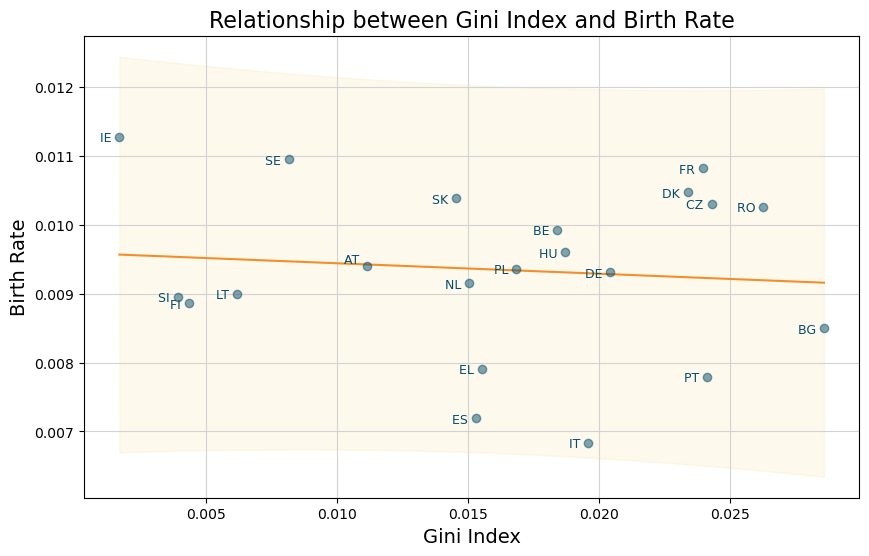

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Define the colors
line_color = "#074C6B" 
fill_color = "#EDC949"
data = dfinal2  # Assuming dfinal is your DataFrame with the data

# Fit a regression model
X = sm.add_constant(data['Gini'])  # adding a constant
model = sm.OLS(data['birth_rate'], X).fit()

# Predict values along the observed range of Moran's I
x_pred = np.linspace(data['Gini'].min(), data['Gini'].max(), 100)
x_pred2 = sm.add_constant(x_pred)  # add constant as we did before
y_pred = model.predict(x_pred2)

# Calculate confidence intervals for the predictions
_, upper, lower = wls_prediction_std(model, exog=x_pred2, alpha=0.05)

# Create a plot with custom colors
plt.figure(figsize=(10, 6))
plt.scatter(x='Gini', y='birth_rate', data=data, color=line_color,alpha=0.5,zorder=3)

# Plot regression line and confidence interval
plt.plot(x_pred, y_pred, '-', color="#F28E2C", label='Regression Line')  # regression line
plt.fill_between(x_pred, lower, upper, color=fill_color, alpha=0.1, label='Confidence Interval')

# Adding labels for each point slightly further from the data points
for i, txt in enumerate(data['Country code']):
    if txt == 'AT':
        plt.text(data['Gini'].iloc[i], data['birth_rate'].iloc[i], txt+'  ', fontsize=9, ha='right', va='bottom',color =line_color )
    else: 
        plt.text(data['Gini'].iloc[i], data['birth_rate'].iloc[i], txt+'  ', fontsize=9, ha='right', va='center_baseline',color =line_color )

# Setting plot title and labels
plt.title('Relationship between Gini Index and Birth Rate', fontsize=16)
plt.xlabel('Gini Index', fontsize=14)
plt.ylabel('Birth Rate', fontsize=14)

# Customizing the grid
ax = plt.gca()  # Get current axis
plt.grid(True, color="lightgray") 

# Saving the figure with a transparent background
plt.savefig('plot_with_transparency.png', transparent=True)

# Displaying the plot
plt.show()

In [161]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             birth_rate   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.1837
Date:                Tue, 07 May 2024   Prob (F-statistic):              0.673
Time:                        21:01:05   Log-Likelihood:                 111.77
No. Observations:                  21   AIC:                            -219.5
Df Residuals:                      19   BIC:                            -217.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.001     15.130      0.0